### **L4 기반(Google pro)**
- **불용어후보(6.19, 수)바탕으로 LDA**

### **한글깨짐 방지 아래 코드 돌리고 재시작**

In [ ]:
# %%capture
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

### **재시작**

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **파일 읽기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import time
import gzip
import pickle
import os


start_time = time.time()

# 현재 디렉토리를 확인합니다.
current_dir = '/content/drive/MyDrive/이대과제/data_gzip'

# 파일 리스트를 가져옵니다.
file_list = [f for f in os.listdir(current_dir) if f.endswith('.pkl.gz')]

# 빈 데이터프레임 리스트를 생성합니다.
df_list = []

# 각 gzip 파일을 읽어 데이터프레임으로 변환하고 리스트에 추가합니다.
for file in file_list:
    try:
        with gzip.open(os.path.join(current_dir, file), 'rb') as f:
            data = pickle.load(f)
            df = pd.DataFrame(data)
            if not df.empty:
                df_list.append(df)
            else:
                print(f"Empty DataFrame in file: {file}")
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# 빈 리스트가 아닌지 확인합니다.
if df_list:
    # 모든 데이터프레임을 하나로 합칩니다.
    df = pd.concat(df_list, ignore_index=True)
else:
    print("No valid DataFrames to concatenate.")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 39.66 seconds


### **prompt: 일자와 언론사가 같은 행만 select**

In [ ]:
df = df[~df.duplicated(['일자', '언론사', '제목'])]
df.shape

(5641608, 8)

In [ ]:
df= df[['일자', '특성추출(가중치순 상위 50개)']]

# df['일자']를 날짜로 변경하고 index로 지정
df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')
df['년도']=df['일자'].apply(lambda x: x.year)
df['월']=df['일자'].apply(lambda x: x.month)

In [ ]:
tf =df.copy()
df= df.sample(frac=0.3)

In [ ]:
df = df.sample(frac=0.005)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **불용어**

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/이대과제/data/불용어후보.xlsx')
print(data.shape)
data.tail()

# 불용어 처리
stop_words = data[data['불용어_0622'] == 1]['단어'].tolist()

(4837, 6)


,단어,불룡어?,유형,이대,불용어_0622,Unnamed: 5
4832,확대,NaN,추가작업_0622,NaN,1,NaN
4833,환경,NaN,추가작업_0622,NaN,0,NaN
4834,회원사,NaN,추가작업_0622,NaN,1,NaN
4835,효율성,NaN,추가작업_0622,NaN,1,NaN
4836,휴가철,NaN,추가작업_0622,NaN,0,NaN


In [ ]:
# corpus 정제
import re

def preprocess_corpus(corpus):
    updated_corpus = []
    pattern_mixed = re.compile(r'(?=.*\d)(?=.*[a-zA-Z가-힣])')
    pattern_korean_english = re.compile(r'^[가-힣a-zA-Z]+$')

    for document in corpus:
        if isinstance(document, str):
            words = document.split(',')
            filtered_words = [word for word in words if pattern_korean_english.match(word) and not pattern_mixed.search(word)]
            updated_corpus.append(','.join(filtered_words))
        else:
            updated_corpus.append('')
    return updated_corpus


## **corpus**

In [ ]:
corpus = []
#for keywords in df['특성추출(가중치순 상위 50개)']:
for keywords in df['특성추출(가중치순 상위 50개)']:
    corpus.append(keywords)
corpus[:2]

# 각 년도별 corpus 정제
cleaned_corpus = preprocess_corpus(corpus)
cleaned_corpus[:2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['분당,성남,파티오,서울,도촌지구,성남시,전원생활,수지구,中庭,잠실,kcc,경기도,용인시,스위첸,도촌,관계자',
 '장학금,청양,장학회,청양사랑인재육성장학회,수여식,장학생,이사장,청양군청,김돈곤,청양군,검정고시,대회의실,교육장,디딤,군의회,장학사업,학생들,청양군수,장학']

['분당,성남,파티오,서울,도촌지구,성남시,전원생활,수지구,잠실,kcc,경기도,용인시,스위첸,도촌,관계자',
 '장학금,청양,장학회,청양사랑인재육성장학회,수여식,장학생,이사장,청양군청,김돈곤,청양군,검정고시,대회의실,교육장,디딤,군의회,장학사업,학생들,청양군수,장학']

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
corpus = cleaned_corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **CountVectorizer, TfidfVectorizer,TfidfTransformer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
vect = CountVectorizer(stop_words = stop_words,
                       ngram_range=(1, 1),
                       min_df= 0.0025,
                       max_df= 0.9)

X = vect.fit_transform(corpus) # Doc-Term Matrix 계산
len(vect.get_feature_names_out())
X

from scipy import sparse
X.toarray()
sparse.csr_matrix(X.toarray())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


342

<8462x342 sparse matrix of type '<class 'numpy.int64'>'
	with 22461 stored elements in Compressed Sparse Row format>

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

<8462x342 sparse matrix of type '<class 'numpy.int64'>'
	with 22461 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame(X.toarray(), columns = vect.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ai,cu,gs,mbc,nh,sbs,sns,tf,가구,가능성,...,홍보활동,화재,확산,환경,환경오염,환자,활동,후원,후쿠시마,휴대전화
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. 사이킷런을 이용한 토픽 모델링
- **[파이썬 텍스트 마이닝 완벽 가이드](https://github.com/wikibook/textmining/blob/main/Ch%2007.%20%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb)**
### **LDA**

In [ ]:
'''
from sklearn.decomposition import LatentDirichletAllocation
# 5개의 주제만 뽑았으니 n_components(토픽개수) 5로 설정
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
# components_속성은 5개의 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌
print(lda.components_.shape)
print(lda.components_)
'''

'\nfrom sklearn.decomposition import LatentDirichletAllocation\n# 5개의 주제만 뽑았으니 n_components(토픽개수) 5로 설정\nlda = LatentDirichletAllocation(n_components=5, random_state=42)\nlda.fit(X)\n# components_속성은 5개의 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌\nprint(lda.components_.shape)\nprint(lda.components_)\n'

## **<font color='blue'> gensim을 이용하여 LDA**

- 하이퍼파라미터 3개 부터 10개 LDA수행 후 토픽 개수 결정
- topic : 당신이 가설로 잡은 토픽의 갯수는?
- chunksize : 얼마나 많은 문서가 훈련 알고리즘에 사용되는가?
- 만약에 빠른 학습이 중요하시다면, 청크사이즈를 키워서 돌려봅시다!
- Hoffman의 논문에 의하면 Chunksize는 모델 품질에 영향을 미치지만 차이그 그렇게 크진 않다고 합니다!
- passes : 패스는 모델 학습시 전체 코퍼스에서 모델을 학습시키는 빈도를 제어한다고 합니다. epochs 와 같은 용어 같다! model를 학습시키는 횟수를 말하는것 같아요! model sampling?
- iteration : 각각 문서에 대해서 루프를 얼마나 돌리는지를 제어한다고 합니다.
pass & iteration 은 최대한 많은게 좋다!
- eval_every = 1 in LdaModel
- alpha, eta = auto, 디리클레 분포의 감마함수에 대한 파라미터입니다!

In [ ]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess # lemmatize is no longer in gensim.utils
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import RegexpTokenizer

In [ ]:
RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text)
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:1: DeprecationWarning: invalid escape sequence '\w'
<>:1: DeprecationWarning: invalid escape sequence '\w'
<ipython-input-36-034c905e8315>:1: DeprecationWarning: invalid escape sequence '\w'
  RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의


In [ ]:
# Check the data types in your DataFrame
print(df['특성추출(가중치순 상위 50개)'].dtypes)

# If the column is not of type string, convert it:
df['특성추출(가중치순 상위 50개)'] = df['특성추출(가중치순 상위 50개)'].astype(str)

texts = [tokenizer(news) for news in df['특성추출(가중치순 상위 50개)']]

object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]

# Create Corpus: Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in data_words if text not in stop_words]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Number of initial unique words in documents: 62200
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 8462


In [ ]:
%%capture
!pip install pyLDAvis

### **혼란도와 토픽 응집도를 이용한 최적값 선택**
- https://github.com/wikibook/textmining/blob/main/Ch%2007.%20%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -7.375, coherence: -6.390


num_topics: 7, perplexity: -7.410, coherence: -6.875


num_topics: 8, perplexity: -7.428, coherence: -7.020


num_topics: 9, perplexity: -7.459, coherence: -8.486


num_topics: 10, perplexity: -7.489, coherence: -9.978


num_topics: 11, perplexity: -7.515, coherence: -9.977


num_topics: 12, perplexity: -7.574, coherence: -10.156


num_topics: 13, perplexity: -7.900, coherence: -11.116


num_topics: 14, perplexity: -8.478, coherence: -10.550
num_topics: 15, perplexity: -8.698, coherence: -11.157


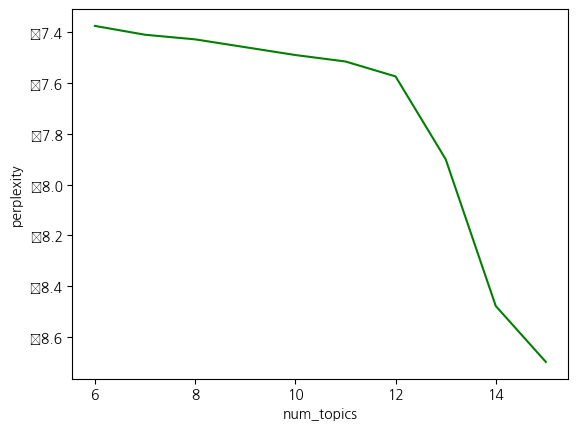

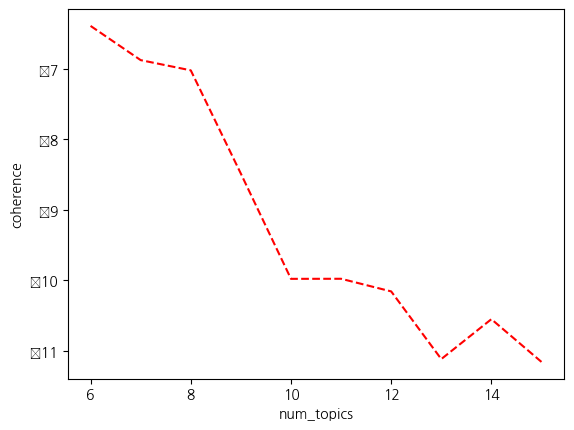

In [ ]:
from gensim.models import CoherenceModel

def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus,
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=3, end=10)

In [ ]:
from gensim.models import LdaModel
import pyLDAvis.gensim # Now this import should work , !pip install pyLDAvis
from tqdm import tqdm
from datetime import date

for num_topics in  tqdm(np.arange(3,10)):
    passes = 5
    %time model = LdaModel(corpus=corpus, id2word=dictionary,\
                           passes=passes, num_topics=num_topics, \
                           random_state=7)

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

    pyLDAvis.save_html(vis, str(num_topics) + '_topics_' + str(date.today()) + '---' + '.html')

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/7 [12:02<?, ?it/s]


NameError: name 'model' is not defined

## **Topic의 개수를 정하고 model을 결정**

In [ ]:
topics = model.print_topics() # (num_words=10)
for topic in topics:
    print(topic)

## **5개의 topic이 최적이라고 판단한다면**

In [ ]:
model = LdaModel(corpus=corpus, id2word=dictionary,\
                           passes=passes, num_topics=5, \
                           random_state=7)

In [ ]:
for topic in  model.print_topics():
    print(topic)

### **LDA 년도별 문서 분포 결과 출력**

### **문서집단(corpus)를 토픽별로 비중을 확인**


In [ ]:
import warnings
warnings.filterwarnings('ignore')

doc_topics =[]
for topic_list in model[corpus]:
    ulist =[]
    for j in range(len(topic_list)):
        ulist.append(topic_list[j][1]) # topic 이 5개인 경우
    doc_topics.append(ulist)

pd.DataFrame(doc_topics)

In [ ]:
pd.DataFrame(doc_topics).sum(1)

### **Assuming 'doc_topics' is defined earlier in your code and used for LDA**
- **5개 topic을 가정하면**

In [ ]:

topic_list = np.argmax(pd.DataFrame(doc_topics).values, axis=1).tolist()

# Sample data (for demonstration purposes, replace with your actual data)
tf = pd.DataFrame({
    '일자': pd.date_range(start='2010-01-01', end='2024-12-31', freq='M'),
    '문서': np.random.randint(0, 100, size=(180,))
})

# Ensure topic_list has the same length as tf
# Assuming 5 topics
topic_num = 5
doc_topics = np.random.rand(len(tf), topic_num)
topic_list = np.argmax(doc_topics, axis=1).tolist()

# LDA 년도별 문서 분포 결과 출력
start_year = 2010
end_year = 2024
result_df = pd.DataFrame()  # Initialize result_df before the loop

for year in range(start_year, end_year + 1):
    start_date = str(year) + "-01-01"
    end_date = str(year) + "-12-31"
    dt_idx = (tf['일자'] >= start_date) & (tf['일자'] <= end_date)
    sub_tf = tf[dt_idx]

    # Ensure indices are within bounds
    valid_indices = [i for i in dt_idx.index[dt_idx] if i < len(topic_list)]
    sub_topic_list = [topic_list[i] for i in valid_indices]

    result = []
    for t in range(max(topic_list) + 1):
        # Count occurrences of each topic in sub_topic_list
        num = sub_topic_list.count(t)
        result.append(num)
    result = pd.Series(result, name=str(year))
    result_df = pd.concat([result_df, result], axis=1)

# 비율로 만들기
result_df = result_df.T.apply(lambda x: x / x.sum(), axis=1)
result_df


In [ ]:
result_df.sum(1)

### 년도별 비중 시각화

In [ ]:
ax = result_df.plot.barh(stacked=True,legend=False,figsize=(25, 10), title="Topic Proportion(%)")
ax.legend(bbox_to_anchor=(1.03, 1),loc=2, borderaxespad=0.)

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f"%(width*100), xy=(left+width/2, bottom+height/2), ha='center', va='center')

## **각 Topic의 추세확인**

In [ ]:
# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]

doc_topics =[]
for topic_list in model[corpus]:
    ulist =[]
    for j in range(len(topic_list)):
        ulist.append(topic_list[j][1]) # topic 이 5개인 경우
    doc_topics.append(ulist)

pd.DataFrame(doc_topics)

In [ ]:
trend_data = pd.DataFrame(doc_topics)
trend_data['start'] = df['일자'].values
trend_data = trend_data.set_index('start')
trend_data = trend_data.resample('M').mean()
trend_data

In [ ]:
fig, axes = plt.subplots(5, 1, sharex='col', figsize=(25, 20))

for col, ax in zip(trend_data.columns.tolist(), axes.ravel()):
    ax.set_title(f'Topic {col}: 월별 추세선', fontsize=18)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend_data[col])

## **END**